In [20]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

df = pd.read_csv("dataset.csv")
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 30
LR = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    import os
    os.environ["TF_ENABLE_ONEDNN_OPTS"]= "0"
except ImportError:
    print("Please check the environment.")
def check_input(df):
    print(df.isna().sum())
    print(df[df['feedback_text'].isna()])
    print(df.columns.tolist())
    print(df.head(10))

check_input(df=df)

id               0
feedback_text    0
sentiment        0
topic            0
urgency          0
action           0
dtype: int64
Empty DataFrame
Columns: [id, feedback_text, sentiment, topic, urgency, action]
Index: []
['id', 'feedback_text', 'sentiment', 'topic', 'urgency', 'action']
   id                                      feedback_text sentiment  \
0   1  We need to streamline the AI demos for all AI ...  negative   
1   2                                 Room size is small  negative   
2   3                 Noise outside the room in the hall  negative   
3   4              The lunch was so cold and food is dry  negative   
4   5                         No variety of food options  negative   
5   6                      Coffee machine is not working  negative   
6   7                         The content is so outdated  negative   
7   8                                          Excellent  positive   
8   9              The instructor is really professional  positive   
9  10           

In [21]:
# create data class
class FeedbackDataset(Dataset):
    def __init__(self, csv_file, tokenizer, rule_based_func=None):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.rule_based_func = rule_based_func or (lambda x: torch.zeros(20))  # 默认规则特征向量长度20

        # 编码标签
        self.sentiment_encoder = LabelEncoder()
        self.sentiment = torch.tensor(self.sentiment_encoder.fit_transform(self.data['sentiment']))
        
        self.urgency_encoder = LabelEncoder()
        self.urgency = torch.tensor(self.urgency_encoder.fit_transform(self.data['urgency']))

        self.topic_encoder = LabelEncoder()
        self.topics = torch.tensor(
            self.topic_encoder.fit_transform(self.data['topic']))

        self.action_encoder = LabelEncoder()
        self.action = torch.tensor(self.action_encoder.fit_transform(self.data['action']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.loc[idx, 'feedback_text']
        rule_vec = self.rule_based_func(text)  # rule-based binary vector

        inputs = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['rule_vec'] = rule_vec
        item['sentiment'] = self.sentiment[idx]
        item['urgency'] = self.urgency[idx]
        item['topic'] = self.topics[idx]
        item['action'] = self.action[idx]
        return item


In [22]:
# rule for bert class
def rule_based_features(text):
    sentiment_words = ["excellent", "terrible", "good", "bad", "love", "hate"]
    urgency_words = ["immediately", "urgent", "asap", "delay"]
    topic_words = ["trainer", "venue", "content", "equipment"]
    all_words = sentiment_words + urgency_words + topic_words

    vector = torch.zeros(len(all_words))
    # print(text, type(text))
    words = text.lower().split()
    for i, w in enumerate(all_words):
        if w in words:
            vector[i] = 1.0
    return vector

In [23]:
class MultiTaskBERT(nn.Module):
    def __init__(self, model_name, rule_dim=20):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.rule_dim = rule_dim
        hidden_size = self.bert.config.hidden_size

        # 冻结除最后两层外的Transformer层
        for name, param in self.bert.named_parameters():
            if "encoder.layer.10" not in name and "encoder.layer.11" not in name:
                param.requires_grad = False

        # 分类头
        self.dropout = nn.Dropout(0.2)
        self.sentiment_classifier = nn.Linear(hidden_size + rule_dim, 3)
        self.urgency_classifier = nn.Linear(hidden_size + rule_dim, 3)
        self.topic_classifier = nn.Linear(hidden_size + rule_dim, 7)  # 多标签
        self.action_classifier = nn.Linear(hidden_size + rule_dim, 6)

    def forward(self, input_ids, attention_mask, rule_vec):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = torch.cat([cls_output, rule_vec], dim=1)
        x = self.dropout(x)
        return {
            "sentiment": self.sentiment_classifier(x),
            "urgency": self.urgency_classifier(x),
            "topic": self.topic_classifier(x),
            "action": self.action_classifier(x)
        }


In [24]:
# do training curve
from sklearn.metrics import f1_score, accuracy_score
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    urg_preds, urg_labels = [], []
    sent_preds, sent_labels = [], []
    f1_scores = {}

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            rule_vec = batch['rule_vec'].to(DEVICE)
            sentiment = batch['sentiment'].to(DEVICE)
            urgency = batch['urgency'].to(DEVICE)

            outputs = model(input_ids, attention_mask, rule_vec)
            s_pred = torch.argmax(outputs['sentiment'], dim=1)
            u_pred = torch.argmax(outputs['urgency'], dim=1)

            sent_preds.extend(s_pred.cpu().numpy())
            sent_labels.extend(sentiment.cpu().numpy())
            urg_preds.extend(u_pred.cpu().numpy())
            urg_labels.extend(urgency.cpu().numpy())

    f1_scores['sentiment'] = f1_score(sent_labels, sent_preds, average='macro')
    f1_scores['urgency'] = f1_score(urg_labels, urg_preds, average='macro')
    acc_sent = accuracy_score(sent_labels, sent_preds)
    acc_urg = accuracy_score(urg_labels, urg_preds)

    print(f"📊 Validation | Sentiment: F1={f1_scores['sentiment']:.3f}, Acc={acc_sent:.3f} | "
          f"Urgency: F1={f1_scores['urgency']:.3f}, Acc={acc_urg:.3f}")

    return {
        "f1_sentiment": f1_scores['sentiment'],
        "f1_urgency": f1_scores['urgency'],
        "acc_sentiment": acc_sent,
        "acc_urgency": acc_urg
    }


In [25]:
# running code
def train_model(model, dataloader, optimizer, scheduler, loss_fn, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            rule_vec = batch['rule_vec'].to(DEVICE)
            sentiment = batch['sentiment'].to(DEVICE)
            urgency = batch['urgency'].to(DEVICE)
            topic = batch['topic'].to(DEVICE)
            action = batch['action'].to(DEVICE)

            outputs = model(input_ids, attention_mask, rule_vec)
            loss = (
                0.2 * loss_fn['ce'](outputs['sentiment'], sentiment)
                + 0.3 * loss_fn['ce'](outputs['urgency'], urgency)
                + 0.4 * loss_fn['ce'](outputs['topic'], topic)
                + loss_fn['ce'](outputs['action'], action)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} average loss: {total_loss / len(dataloader):.4f}")

In [ ]:
# train - val loop
def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, num_epochs):
    train_losses, val_f1s = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            rule_vec = batch['rule_vec'].to(DEVICE)
            sentiment = batch['sentiment'].to(DEVICE)
            urgency = batch['urgency'].to(DEVICE)
            topic = batch['topic'].to(DEVICE)
            action = batch['action'].to(DEVICE)

            outputs = model(input_ids, attention_mask, rule_vec)
            loss = (
                0.25 * loss_fn['ce'](outputs['sentiment'], sentiment)
                + 0.25 * loss_fn['ce'](outputs['urgency'], urgency)
                + 0.35 * loss_fn['ce'](outputs['topic'], topic)
                + 0.15 * loss_fn['ce'](outputs['action'], action)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"✅ Epoch {epoch+1} | Train Loss: {avg_loss:.4f}")

        # 验证阶段
        val_metrics = evaluate(model, val_loader)
        val_f1s.append((val_metrics['f1_sentiment'] + val_metrics['f1_urgency']) / 2)

    return train_losses, val_f1s



Epoch 1/30: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


✅ Epoch 1 | Train Loss: 1.4959
📊 Validation | Sentiment: F1=0.208, Acc=0.455 | Urgency: F1=0.271, Acc=0.545


Epoch 2/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 2 | Train Loss: 1.4258
📊 Validation | Sentiment: F1=0.208, Acc=0.455 | Urgency: F1=0.281, Acc=0.568


Epoch 3/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 3 | Train Loss: 1.3495
📊 Validation | Sentiment: F1=0.251, Acc=0.477 | Urgency: F1=0.349, Acc=0.614


Epoch 4/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 4 | Train Loss: 1.2730
📊 Validation | Sentiment: F1=0.412, Acc=0.591 | Urgency: F1=0.478, Acc=0.727


Epoch 5/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 5 | Train Loss: 1.1994
📊 Validation | Sentiment: F1=0.582, Acc=0.705 | Urgency: F1=0.521, Acc=0.773


Epoch 6/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 6 | Train Loss: 1.1076
📊 Validation | Sentiment: F1=0.582, Acc=0.705 | Urgency: F1=0.560, Acc=0.818


Epoch 7/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 7 | Train Loss: 1.0147
📊 Validation | Sentiment: F1=0.639, Acc=0.727 | Urgency: F1=0.560, Acc=0.818


Epoch 8/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 8 | Train Loss: 0.9419
📊 Validation | Sentiment: F1=0.662, Acc=0.750 | Urgency: F1=0.576, Acc=0.841


Epoch 9/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 9 | Train Loss: 0.8574
📊 Validation | Sentiment: F1=0.662, Acc=0.750 | Urgency: F1=0.612, Acc=0.886


Epoch 10/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 10 | Train Loss: 0.7772
📊 Validation | Sentiment: F1=0.658, Acc=0.750 | Urgency: F1=0.630, Acc=0.909


Epoch 11/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 11 | Train Loss: 0.7262
📊 Validation | Sentiment: F1=0.751, Acc=0.818 | Urgency: F1=0.630, Acc=0.909


Epoch 12/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 12 | Train Loss: 0.6591
📊 Validation | Sentiment: F1=0.749, Acc=0.818 | Urgency: F1=0.630, Acc=0.909


Epoch 13/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 13 | Train Loss: 0.6160
📊 Validation | Sentiment: F1=0.749, Acc=0.818 | Urgency: F1=0.630, Acc=0.909


Epoch 14/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 14 | Train Loss: 0.5604
📊 Validation | Sentiment: F1=0.842, Acc=0.864 | Urgency: F1=0.608, Acc=0.864


Epoch 15/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 15 | Train Loss: 0.5351
📊 Validation | Sentiment: F1=0.861, Acc=0.886 | Urgency: F1=0.608, Acc=0.864


Epoch 16/30: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


✅ Epoch 16 | Train Loss: 0.4978
📊 Validation | Sentiment: F1=0.861, Acc=0.886 | Urgency: F1=0.630, Acc=0.909


Epoch 17/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 17 | Train Loss: 0.4761
📊 Validation | Sentiment: F1=0.861, Acc=0.886 | Urgency: F1=0.608, Acc=0.864


Epoch 18/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 18 | Train Loss: 0.4721
📊 Validation | Sentiment: F1=0.861, Acc=0.886 | Urgency: F1=0.608, Acc=0.864


Epoch 19/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 19 | Train Loss: 0.4395
📊 Validation | Sentiment: F1=0.861, Acc=0.886 | Urgency: F1=0.608, Acc=0.864


Epoch 20/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 20 | Train Loss: 0.4262
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 21/30: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


✅ Epoch 21 | Train Loss: 0.4091
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 22/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 22 | Train Loss: 0.4064
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 23/30: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


✅ Epoch 23 | Train Loss: 0.3882
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 24/30: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


✅ Epoch 24 | Train Loss: 0.3930
📊 Validation | Sentiment: F1=0.882, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 25/30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


✅ Epoch 25 | Train Loss: 0.3775
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.596, Acc=0.841


Epoch 26/30: 100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


✅ Epoch 26 | Train Loss: 0.3831
📊 Validation | Sentiment: F1=0.882, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 27/30: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


✅ Epoch 27 | Train Loss: 0.3655
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 28/30: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


✅ Epoch 28 | Train Loss: 0.3622
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 29/30: 100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


✅ Epoch 29 | Train Loss: 0.3544
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


Epoch 30/30: 100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


✅ Epoch 30 | Train Loss: 0.3566
📊 Validation | Sentiment: F1=0.879, Acc=0.909 | Urgency: F1=0.608, Acc=0.864


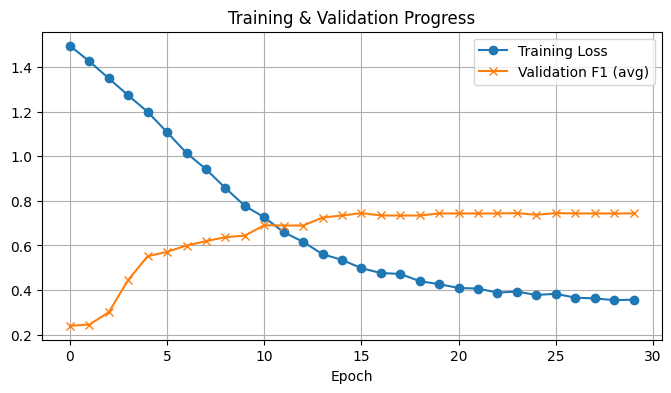

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("dataset.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
train_dataset = FeedbackDataset("train.csv", tokenizer, rule_based_features)
val_dataset = FeedbackDataset("val.csv", tokenizer, rule_based_features)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = MultiTaskBERT(MODEL_NAME, rule_dim=14).to(DEVICE)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = {"ce": nn.CrossEntropyLoss(), "bce": nn.BCEWithLogitsLoss()}
train_losses, val_f1s = train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, EPOCHS)

# 绘制训练损失与验证F1
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_f1s, label='Validation F1 (avg)', marker='x')
plt.title("Training & Validation Progress")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()
